# Parallelising emcee using IPython parallel

MCMC simulations are good candidates for parallelisation, especially when trying to 
produce enough samples to get smooth approximations of the posterior. The [emcee](http://dan.iel.fm/emcee/current/) program comes with a `threads` option, but it doesn't really speed up many typical use cases.
To explain this I refer to to emcee docs:

>It is also important to note that the multiprocessing module works by spawning a large number of new python processes and running the code in isolation within those processes. This means that there is a significant amount of overhead involved at each step of the parallelization process. With this in mind, it is not surprising that running a simple problem like the quickstart example in parallel will run much slower than the equivalent serial code. If your log-probability function takes a significant amount of time (> 1 second or so) to compute then using the parallel sampler actually provides significant speed gains.

In addition there are issues around pickling functions which would require editing the emcee code
to use `dill`: something I don't really want to do. Instead, we can turn to the [IPython parallel computing tools](http://ipython.org/ipython-doc/dev/parallel/). A typical use case would be to get each core on your personal computer to run the production chain, then combine the results from all the parallel results. 

In this notebook I will use the [quickstart example](http://dan.iel.fm/emcee/current/user/quickstart/#quickstart) from 
emcee and show how to do this. 

## The quickstart example

Firstly I have taken the quickstart example and stripped out all the plot creation to leave *just* the minimum working example for testing. If you want to know more about the example go read the quickstart. 

In [1]:
%matplotlib inline

from __future__ import print_function

import emcee
import triangle
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator


# Reproducible results!
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# Define the probability function as likelihood * prior.
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))

# Set up the sampler.
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

The `sampler` objects contains the `run_mcmc` method which will run the simulations. First let's define the number of points and a suitable burnin period:

In [2]:
npoints = 1000
burnin = 100

## Results without multiprocessing

Firstly we run the sampler *normaly*, that is without any multiprocessing and we will plot the corner plot so we know what the results **should** look like, and print the shape of the samples so we know what to expect:

(90000, 3)


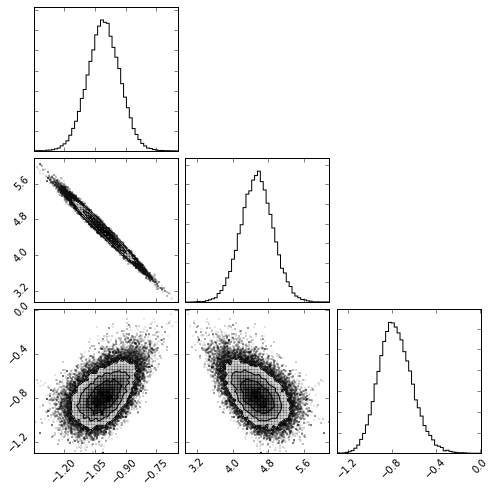

In [3]:
sampler.reset()
out = sampler.run_mcmc(pos, npoints, rstate0=np.random.get_state())
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

print(samples.shape)
fig = triangle.corner(samples)
plt.show()

## Results with multiprocessing (the sanity check)

Now we know what the results should look like, we will show first how to parallelise the simulations and then
check that the results are consistent with the normal method.

### The method

Here we create a function `run` which takes a view, and some arguments which should be fairly readable. The only important point here is that we take the total number of poinst we want `npoints` and divide it among the number of 
cores available. If the total number of points doesn't factor nicely among the threads then we may loose or gain a point here and there. 

In [4]:
import os,sys,time
import numpy as np

from IPython import parallel
rc = parallel.Client()
dview = rc[:]
dview.block = True
dview.use_dill()  # Standard pickle fails with functions

local_dict = {'lnprior': lnprior,
              'lnlike': lnlike,
              'lnpron': lnprob,
              'ndim': ndim}

def run(dview, pos, sampler, local_dict, npoints, burnin):
    for key, val in local_dict.items():
        dview[key] = val
        
    dview['burnin'] = burnin
    dview["npernode"] = int(npoints/len(dview))
    dview['sampler'] = sampler
    dview['pos'] = pos
    dview['lnprior'] = lnprior
    dview.execute("sampler.run_mcmc(pos, npernode, rstate0=np.random.get_state())\n"+
                  "samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))")
    return dview.gather("samples")


### Run and produce results

(60000, 3)


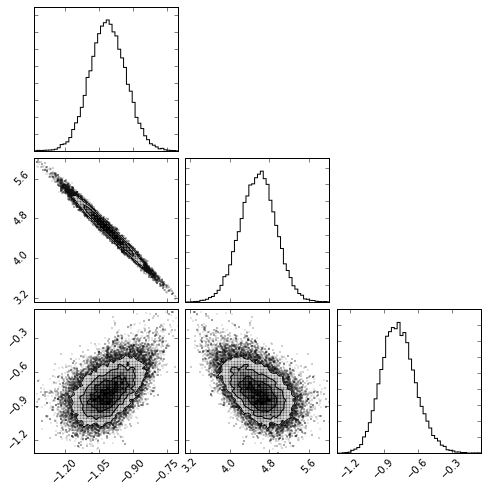

In [5]:
sampler.reset()
samples = run(dview, pos, sampler, local_dict, npoints, burnin)
print(samples.shape)
fig = triangle.corner(samples)
plt.show()

## Timing the results

### The normal way:

In [6]:
%%timeit
sampler.reset()
out = sampler.run_mcmc(pos, npoints, rstate0=np.random.get_state())
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

1 loops, best of 3: 7.36 s per loop


### Parrallelising with `IPython`

In [7]:
%%timeit 
sampler.reset()
samples = run(dview, pos, sampler, local_dict, npoints, burnin)

1 loops, best of 3: 4.76 s per loop


### Using the `emcee` threads option

In [8]:
sampler_threads = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr), threads=4)
%timeit out = sampler_threads.run_mcmc(pos, npoints, rstate0=np.random.get_state())

1 loops, best of 3: 14.4 s per loop


## Conclusion

This gives us a significant speed up, with very little effort. This solution was produced when 
attending the Next-Generation Computer modelling course hosted by the University of Southampton and 
in particular the IPython notebook sessions given by Min RK a core developer. Thanks to him for some
hints. 

## EDIT: An additional method

Since first writing this I have found that the author of `emcee` was well aware of this trick and had already
written an [example using a slightly different method](https://github.com/dfm/emcee/blob/master/examples/ipython_parallel.py). In this method we initialise the sampler and give the `pool` object the view of the parallel engines. However, it isn't clear to me at the moment how to split the runs between the engines and recover the output. Running with something like:

In [ ]:
from IPython.parallel import Client
c = Client()
view = c[:]
view.push({"lnprob": lnprob, "lnprior": lnprior, "lnlike": lnlike})
view.execute("import numpy as np")

view.push({"lnprob": lnprob})
view.execute("import numpy as np")
sampler_poolview = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr), pool=view)
out = sampler_poolview.run_mcmc(pos, npoints)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
print(samples.shape)
fig = triangle.corner(samples)

Just runs `npoints` on all the engines, but I don't see how to recover the result from the other engines..If you know then please do let me know!